## Dog Breed Prediction

In this project, I will use Keras and TensorFlow to:

* Create, train, and test a Convolutional Neural Network (CNN)

* Recognize the breed of a dog from a given image

* Solve this as a supervised learning task, specifically a multiclass classification problem

In [1]:
# Create a new kaggle api from your kaggle account. A kaggle.json file will be downloaded
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"olayinkaesther","key":"8a04bf741e7a5c4b45d621c9a6811c2b"}'}

Connecting to Kaggle via the Kaggle API, which was downloaded from the Kaggle account settings and uploaded here (upload box).

In [2]:
# Next, install the Kaggle API client using pip install
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Setting up Kaggle using Kaggle API.

In [4]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


To store the data I created a new directory and make it as current working directory.

In [5]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                         size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  ----------  --------------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp   724495926  2020-06-26 03:09:05.433000           8101         10  0.1764706        


Searching Kaggle for the required dataset using search option(-s) with title 'dogbreedidfromcomp'.

In [6]:
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 99% 687M/691M [00:06<00:00, 184MB/s]
100% 691M/691M [00:06<00:00, 113MB/s]
/content


In [7]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [26]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.optimizers import Adam

Importing required libraries.

In [9]:
# Read the labels.csv file and checking shape and records
labels_df = pd.read_csv("dog_dataset/labels.csv")
print(labels_df.shape)
labels_df.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


The label dataset contains 10222 rows and 2 columns.  

In [10]:
# Visualize the number of each breeds
breeds_df = labels_df["breed"]
breed_counts = breeds_df.value_counts()
breed_counts.head()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


Finding out the count per class i.e. total data in each class using value_counts() function.

In [11]:
# Selecting first 3 breeds (Limitation due to computation power)
class_names = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_df[(labels_df['breed'].isin(class_names))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [12]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = class_names)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:01<00:00, 277.07it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In the cell above, I one-hot encoded the target classes, read the images, converted them into NumPy arrays, and normalized the arrays.

In [13]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [43]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
#model.add(Dropout(0.1))
model.add(Dense(len(class_names), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 109, 109, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 52, 52, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 24, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841,827 (3.21 MB)

 Trainable params: 841,827 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In the cell above, I created the network architecture for the model. I used different types of layers based on their functions:

Conv2D: Created convolutional kernels that were convolved with the input to produce output tensors.

MaxPooling2D: Applied downsampling by taking the maximum value over the defined pool size.

Flatten: Flattened the input into a 1D output.

Dense: Produced the output as the dot product of the input and the kernel.


After defining the network architecture, There was 162,619 parameters.

In [44]:
# Training the model
epochs = 20
batch_size = 32

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 557ms/step - accuracy: 0.2903 - loss: 6.9499 - val_accuracy: 0.3385 - val_loss: 6.7560
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.3308 - loss: 6.6974 - val_accuracy: 0.3385 - val_loss: 6.5103
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.3839 - loss: 6.4513 - val_accuracy: 0.3385 - val_loss: 6.2788
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.3961 - loss: 6.2172 - val_accuracy: 0.3538 - val_loss: 6.0631
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.4104 - loss: 6.0163 - val_accuracy: 0.4154 - val_loss: 5.8482
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.4107 - loss: 5.8019 - val_accuracy: 0.5846 - val_loss: 5.6352
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.4924 - loss: 5.5861 - val_accuracy: 0.5385 - val_loss: 5.4300
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.5737 - loss: 5.3738 - val_accuracy: 0.6769 - val_loss:

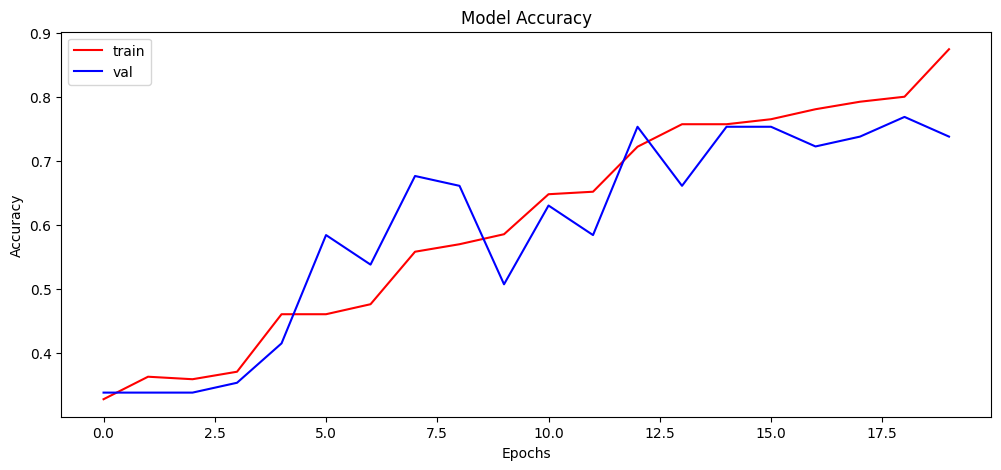

In [45]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

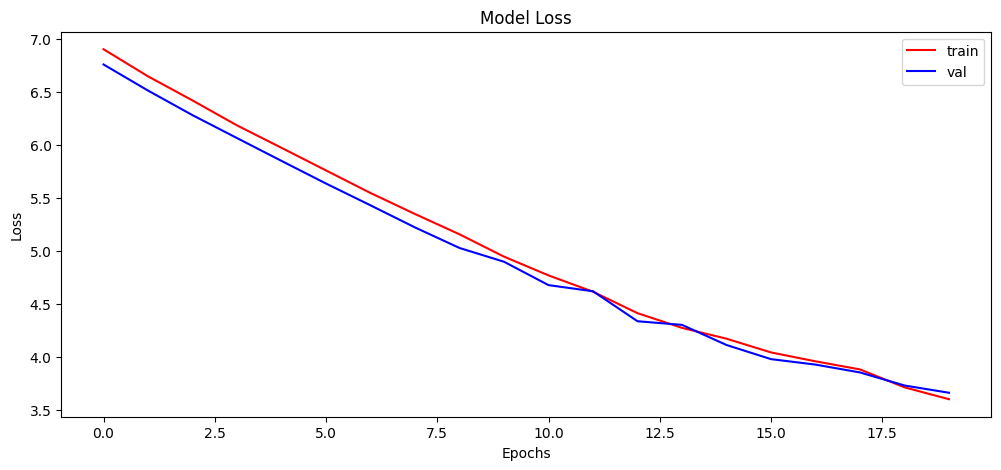

In [46]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

The graghs above show how the model is learning with each epoch in terms of accuracy and loss.

In [48]:
# Predict and Evaluate the model
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)

print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7315 - loss: 3.8477
Accuracy over the test set: 
  72.22 %


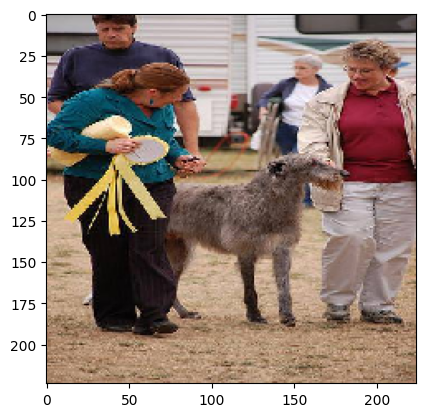

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [49]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

Above, the original image was compared to the predicted image